# Amazon ML Challenge
## Product Browse Node Classification
Amazon catalog consists of billions of products that belong to thousands of browse nodes (each browse node represents a collection of items for sale). Browse nodes are used to help customer navigate through our website and classify products to product type groups. Hence, it is important to predict the node assignment at the time of listing of the product or when the browse node information is absent.

##AIM
Use product metadata to classify products into browse nodes.

## Evaluation Criteria 
This contest uses <mark>Accuracy as the evaluation</mark> metric to measure submissions quality. Since this is a <mark>multiclass classification problem, we are interested in subset accuracy</mark>: the set of labels predicted for a sample must exactly match the corresponding set of ground truth labels.


# Get the Data

In [ ]:
!sudo curl https://s3-ap-southeast-1.amazonaws.com/he-public-data/dataset52a7b21.zip -OJL

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1012M  100 1012M    0     0  57.9M      0  0:00:17  0:00:17 --:--:-- 61.6M


In [ ]:
!unzip dataset52a7b21.zip 

Archive:  dataset52a7b21.zip
   creating: dataset/
  inflating: dataset/train.csv       
  inflating: dataset/sample_submission.csv  
  inflating: dataset/test.csv        
  inflating: dataset/.~lock.train.csv#  


In [3]:
# Variables for loading data from gdrive
root_dir = "Dataset"
prj_dir = "Amazon ML Challenge"
sub_dir = "Product Browse Node Classification"

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
#Load preprocessed dataset
train_df = pd.read_json('/content/gdrive/MyDrive/{}/{}/{}/train_df.json'.format(root_dir, prj_dir, sub_dir), lines=False)
test_df = pd.read_json('/content/gdrive/MyDrive/{}/{}/{}/test_df.json'.format(root_dir, prj_dir, sub_dir), lines=False)
valid_df = pd.read_json('/content/gdrive/MyDrive/{}/{}/{}/valid_df.json'.format(root_dir, prj_dir, sub_dir), lines=False)
train_df.head(3)

,BRAND,BROWSE_NODE_ID,concatenated_text
1405796,17257,1681,protects cars number plates kind damagevehicle...
2730887,101678,150,toys gamessmash vehicles send hulks flying tow...
2318313,88288,15024,efficient could add four 6gbpss sata 30 devic...


# Importing Libraries

In [1]:
!pip install html2text
!pip install missingno
!pip install scikit-learn==0.24.2

     |████████████████████████████████| 22.3 MB 57.8 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import re
import nltk
import gc
import missingno as msno
import string as stringlib
import tensorflow as tf
from tensorflow import keras
from html2text import html2text

from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

nltk.download('stopwords')
STOPWORDS = set([word.lower() for word in stopwords.words('english')])
sns.set_theme()
print("TF version", tf.__version__)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
TF version 2.5.0


In [5]:
gc.collect()

22

In [ ]:
train_df = pd.read_csv("/content/dataset/train.csv", escapechar = "\\", quoting = csv.QUOTE_NONE)
train_df.head()

,TITLE,DESCRIPTION,BULLET_POINTS,BRAND,BROWSE_NODE_ID
0,"Pete The Cat Bedtime Blues Doll, 14.5 Inch","Pete the Cat is the coolest, most popular cat ...","[Pete the Cat Bedtime Blues plush doll,Based o...",MerryMakers,0
1,"The New Yorker NYHM014 Refrigerator Magnet, 2 ...",The New Yorker Handsome Cello Wrapped Hard Mag...,[Cat In A Tea Cup by New Yorker cover artist G...,The New Yorker,1
2,The Ultimate Self-Sufficiency Handbook: A Comp...,NaN,Skyhorse Publishing,imusti,2
3,Amway Nutrilite Kids Chewable Iron Tablets (100),NaN,"[Nutrilite Kids,Chewable Iron Tablets,Quantity...",Amway,3
4,Teacher Planner Company A4 6 Lesson Academic T...,NaN,NaN,NaN,4


In [ ]:
train_df.shape

(2903024, 5)

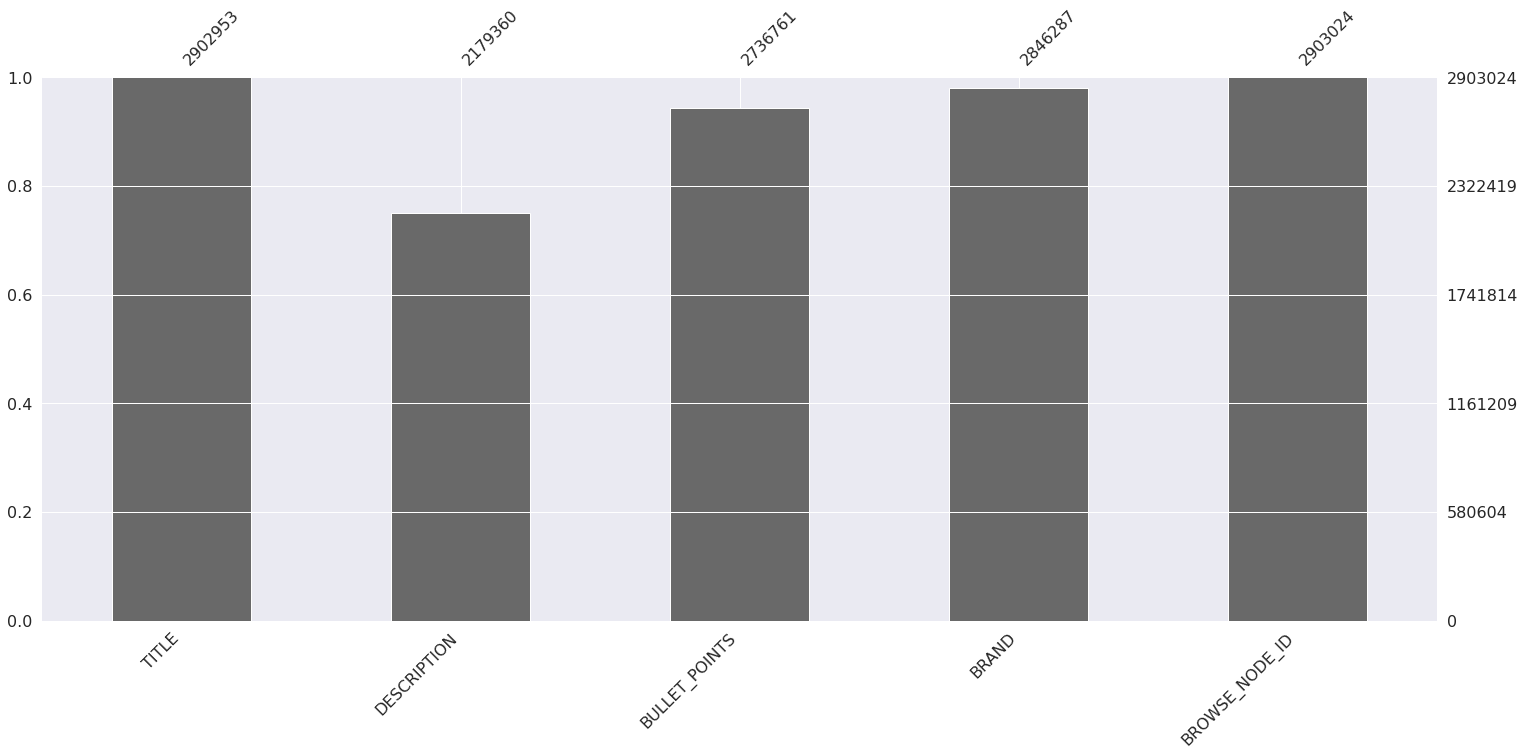

In [ ]:
plt.figure(figsize=(5, 2))
msno.bar(train_df)

In [ ]:
train_df['BRAND'].nunique()

258265

In [ ]:
train_df['BROWSE_NODE_ID'].nunique()

9919

In [ ]:
org_test_df = pd.read_csv("/content/dataset/test.csv", escapechar = "\\", quoting = csv.QUOTE_NONE)
org_test_df.head(3)

,PRODUCT_ID,TITLE,DESCRIPTION,BULLET_POINTS,BRAND
0,1,"Command 3M Small Kitchen Hooks, White, Decorat...",Sale Unit: PACK,[INCLUDES - 9 hooks and 12 small indoor strips...,Command
1,2,O'Neal Jump Hardware JAG Unisex-Adult Glove (B...,Synthetic leather palm with double-layer thumb...,[Silicone printing for a better grip. Long las...,O'Neal
2,3,"NFL Detroit Lions Portable Party Fridge, 15.8 ...",Boelter Brands lets you celebrate your favorit...,[Runs on 12 Volt DC Power or 110 Volt AC Power...,Boelter Brands


# Exploratory Data Analysis

## Split the Training data for testing and validation.

In [ ]:
train_df, test_df = train_test_split(train_df, test_size=0.1, random_state=42)
train_df, valid_df = train_test_split(train_df, test_size=0.1, random_state=42)

In [ ]:
train_df.head()

,BRAND,BROWSE_NODE_ID,concatenated_text
1287536,BigClubb,758,condition compatible high backup mobile batte...
2895273,COIR GARDEN,5236,pack 3 size 18 x 6 inches hdpe g...
1268617,Mothercare,1922,100 cottonknee lengthalinemachine wash mothe...
666996,Generic,12085,moto provide better quality customersfine fur...
1805831,Herschel Supply Co.,1454,signature striped fabric linerinternal storage...


In [ ]:
print("Train set shape:", train_df.shape)
print("Test set shape:", test_df.shape)
print("Valid set shape:", test_df.shape)

Train set shape: (2351448, 5)
Test set shape: (290303, 5)
Valid set shape: (290303, 5)


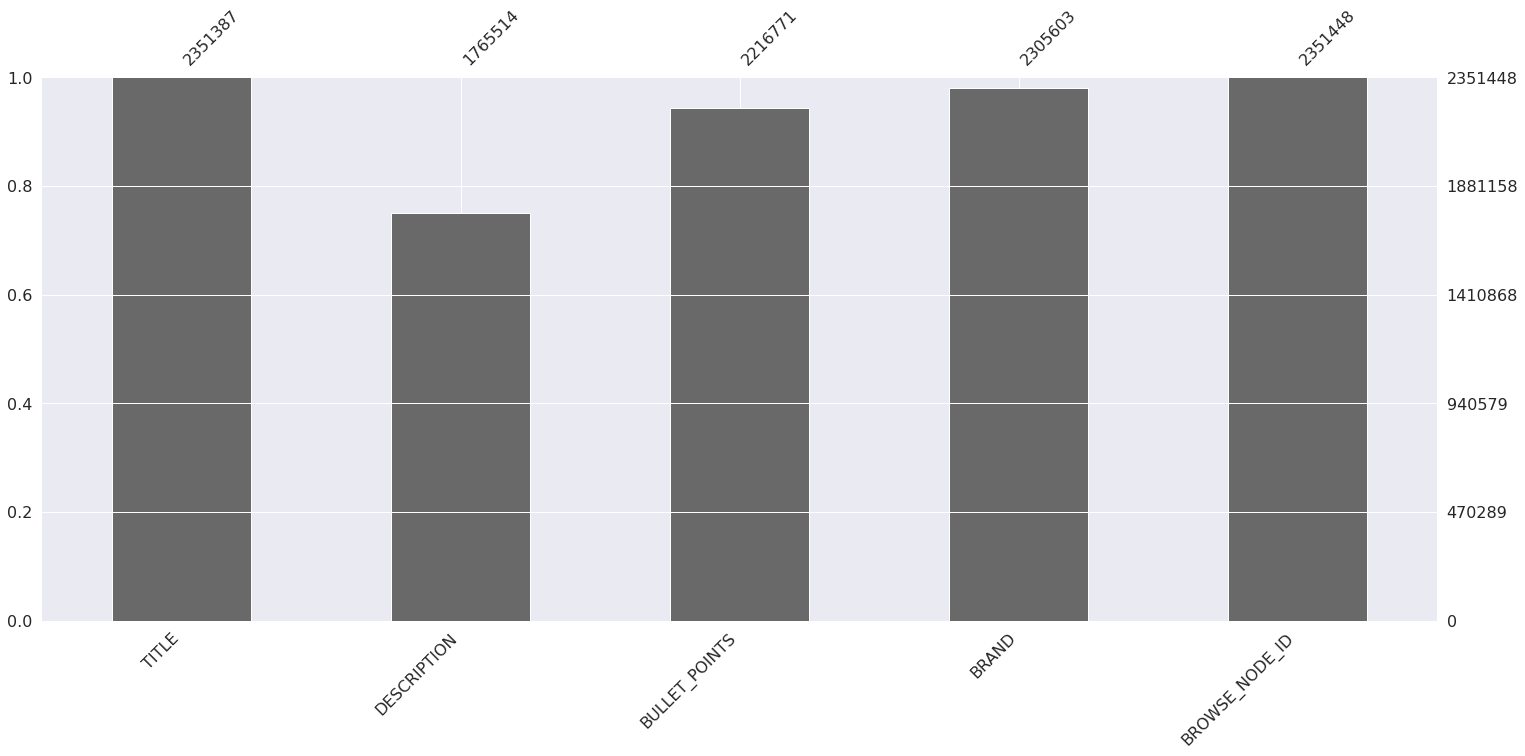

In [ ]:
plt.figure(figsize=(5, 2))
msno.bar(train_df)

In [ ]:
train_df['BRAND'].value_counts()

Generic                      86861
Puma                         11464
United Colors of Benetton     9503
Max                           9101
US Polo Association           6944
                             ...  
Yijueled                         1
Venn Designn                     1
hasejaa                          1
Newdong                          1
QianLink                         1
Name: BRAND, Length: 232710, dtype: int64

In [ ]:
train_df['BRAND'].nunique()

232710

In [ ]:
# 9919 in original data
train_df['BROWSE_NODE_ID'].nunique()

9751

## Let's do a little bit of cleanup

In [ ]:
rep = {"[": "", "]": "","|": " ", "\n": " ",
       "---": " ", "**": " ", "*": "", ":": " ", 
      "#####": " ", "_": " ", "(": " ", ")": " "}
rep = dict((re.escape(k), v) for k, v in rep.items()) 
pattern = re.compile("|".join(rep.keys()))
emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)

def bullet_filter(string):
  """Remove '[', ']' and filter out stopwords and form a single string"""
  string = html2text(string)
  string = pattern.sub(lambda m: rep[re.escape(m.group(0))], string)
  string = re.sub('[%s]' % re.escape(stringlib.punctuation), '' , string)
  string = emoji_pattern.sub(r'', string)                                   # remove emoji
  string = " ".join([word.lower() for word in string.split(" ") if word.lower() not in STOPWORDS])
  return string

def filter(string):
  """Filter DESCRIPTION and TITLE column"""
  string = html2text(string)                                                # remove html
  string = emoji_pattern.sub(r'', string)                                   # remove emoji
  string = re.sub('[%s]' % re.escape(stringlib.punctuation), '' , string)   # remove punctuation
  string = pattern.sub(lambda m: rep[re.escape(m.group(0))], string)        # remove redundant symbols, etc.
  string = " ".join([word.lower() for word in string.split(" ") if word.lower() not in STOPWORDS]) # remove stopwords convert lowercase
  return string

Perform some test

In [ ]:
print(train_df['BULLET_POINTS'].iloc[1])
bullet_filter(train_df['BULLET_POINTS'].iloc[1])

[<br>Pack of 3<br>,<br>Size - 18 x 6 Inches<br>,<br>HDPE Grow Bags for Vegetable Plants, Spinach<br>]


'brpack 3brbrsize  18 x 6 inchesbrbrhdpe grow bags vegetable plants spinachbr'

In [ ]:
print(train_df['TITLE'].iloc[1])
filter(train_df['TITLE'].iloc[1])

COIR GARDEN HDPE Grow Bags for Vegetable Plants, Spinach (18 x 6 Inches) - Pack of 3


'coir garden hdpe grow bags vegetable plants spinach 18 x 6 inches  pack 3  '

In [ ]:
print("[Original]", train_df['DESCRIPTION'].iloc[1])
filter(train_df['DESCRIPTION'].iloc[1])

[Original] Terrace Gardening HDPE Grow Bags for Vegetable Plants, Spinach (Keerai, Palak Plant Grow Bags) (18"x6" inches) - [46cms(L) X 15cms(H)] - Pack of 3


'terrace gardening hdpe grow bags vegetable plants spinach keerai palak plant grow bags 18x6 inches  46cmsl x 15cmsh  pack 3  '

In [ ]:
def drop_unused_cols(df, cols):
  df = df.drop(cols, axis=1)
  return df

In [ ]:
def filter_and_concatenate_cols(df):
  df['BULLET_POINTS'] = df['BULLET_POINTS'].astype(str).map(bullet_filter)  
  df['TITLE']  = df['TITLE'].astype(str).map(filter)
  df['DESCRIPTION'] = df['DESCRIPTION'].astype(str).map(filter)
  df['concatenated_text'] = df[['BULLET_POINTS', 'TITLE', 'DESCRIPTION']].apply(lambda x: ' '.join(x.str.lower()), axis = 1)
  df = df.drop([ 'TITLE', 'DESCRIPTION', 'BULLET_POINTS'], axis=1)
  return df

In [ ]:
train_df = filter_and_concatenate_cols(train_df)
train_df.head(3)

,BRAND,BROWSE_NODE_ID,concatenated_text
0,MerryMakers,0,pete cat bedtime blues plush dollbased popular...
1,The New Yorker,1,cat tea cup new yorker cover artist gurbuz dog...
2,imusti,2,skyhorse publishing ultimate selfsufficiency...


In [ ]:
valid_df = filter_and_concatenate_cols(valid_df)
valid_df.head(3)

In [ ]:
test_df = filter_and_concatenate_cols(test_df)
test_df.head(3)

,BRAND,BROWSE_NODE_ID,concatenated_text
2297143,AMSIK,32296,small smart mirror works together side mirror ...
2078681,Nivea,35,nivea face sun block whitening cream spf 50 pa...
1125035,ROZVEH,1724,material super fine rayon brown floral print ...


In [ ]:
gc.collect()

41

In [ ]:
# Save this Training dataframe for future use
with open('/content/gdrive/MyDrive/{}/{}/{}/train_df.json'.format(root_dir, prj_dir, sub_dir), 'w') as f:
    f.write(train_df.to_json())

In [ ]:
with open('/content/gdrive/MyDrive/{}/{}/{}/valid_df.json'.format(root_dir, prj_dir, sub_dir), 'w') as f:
    f.write(valid_df.to_json())

In [ ]:
with open('/content/gdrive/MyDrive/{}/{}/{}/test_df.json'.format(root_dir, prj_dir, sub_dir), 'w') as f:
    f.write(test_df.to_json())

## Using TensorFlow for preprocessing and data preparation


In [6]:
# Convert `BRAND` column to categories
ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
ordinal_encoder.fit(pd.concat([ train_df[['BRAND']], 
                                 valid_df[['BRAND']] ]))
def to_categorical(frame):
  frame['BRAND'] = frame[['BRAND']].fillna("others")

  frame['BRAND'] = ordinal_encoder.transform(frame[['BRAND']])
  return frame

In [ ]:
# Convert `BRAND` column to one hot
onehot_encoder = OneHotEncoder(handle_unknown='ignore')
onehot_encoder.fit(pd.concat([ train_df[['BRAND']], 
                               valid_df[['BRAND']] ]))
new_columns = list()
for value in onehot_encoder.categories_:
  new_columns.extend("brand_"+str(value))

def to_onehot(frame):
  frame['BRAND'] = frame[['BRAND']].fillna("others")

  onehotlabels = onehot_encoder.transform(frame[['BRAND']]).toarray()
  frame = pd.concat([frame, pd.DataFrame(onehotlabels, columns=new_columns)], axis='columns')
  return frame

In [ ]:
train_df = to_categorical(train_df)
valid_df = to_categorical(valid_df)
gc.collect()
train_df.head(3)

,BRAND,BROWSE_NODE_ID,concatenated_text
1405796,17257.0,1681,protects cars number plates kind damagevehicle...
2730887,101678.0,150,toys gamessmash vehicles send hulks flying tow...
2318313,88288.0,15024,efficient could add four 6gbpss sata 30 devic...


In [ ]:
valid_df.head()

,BRAND,BROWSE_NODE_ID,concatenated_text
1656678,216610.0,1002,nan handheld portable digital screen 200 pre...
955707,150723.0,22,naturalnonheated nontreated gemstoneall diffe...
941819,201414.0,1922,fabric woollength knee length wish karo ba...
1521744,174255.0,4,100 polyester yarn backing material anti sk...
1616169,106008.0,368,material type canvaslifestyle casualclosure ...


### Let's split the data to training/validation data and labels

### Tokenize the training/Validation data.

In [7]:
# Hyperparameters
vocab_size = 30_000
embedding_dim = 64
max_length = 100
num_oov_buckets = 1000
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'
training_portion = 0.8

In [8]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_df['concatenated_text'])

In [9]:
word_index = tokenizer.word_index
list(word_index.items())[:10]

[('<OOV>', 1),
 ('quality', 2),
 ('case', 3),
 ('material', 4),
 ('cover', 5),
 ('size', 6),
 ('made', 7),
 ('x', 8),
 ('1', 9),
 ('design', 10)]

In [10]:
def text_tokenizer(df):
  sequences = tokenizer.texts_to_sequences(df['concatenated_text'])
  sequences = pad_sequences(sequences, 
                            maxlen=max_length,
                            padding=padding_type,
                            truncating=trunc_type)
  print(sequences.shape)
  return sequences

In [11]:
training_sequences = text_tokenizer(train_df)
gc.collect()
training_sequences[0]

(1904672, 100)


array([  200,  1250,   447,  1582,   850,     1,   666, 22993,     1,
         977,  2454,   635,   174,  2916,   261,   454,   352,     1,
         196,     1,    24,   119,   278,    98,   810, 19384,    82,
         447,   954,   278,    30,   254,   191,    16, 12100, 22993,
         362,   447,   954,   278, 20972,    28,  1250,   447,   954,
         278,   200,    82,   447,  1582,   850,   432,    13,    75,
         213,   191,   995,  4676,   954,  1489,  2480,    13,   593,
          15,    11,    15,  1965,  1049,     7,    14,     2,    64,
         419,     1,  2420,     6,   278,   147,   878,  9703,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0], dtype=int32)

In [12]:
validation_sequences = text_tokenizer(valid_df)
gc.collect()

(211631, 100)


0

### Tokenize the Labels

In [13]:
lbl_tokenizer = Tokenizer(lower=False)
lbl_tokenizer.fit_on_texts(train_df['BROWSE_NODE_ID'].astype(str)) 

def label_tokenizer(df):
  label_seq = np.array(lbl_tokenizer.texts_to_sequences(df['BROWSE_NODE_ID'].astype(str)))
  return label_seq

In [14]:
training_label_seq = label_tokenizer(train_df)
print(training_label_seq[0])
print(training_label_seq[1])
gc.collect()

[1581]
[538]


0

In [15]:
validation_label_seq = label_tokenizer(valid_df)
print(validation_label_seq[0])
print(validation_label_seq.shape)
gc.collect()

[318]
(211631,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """


0

# Implement LSTM model

In [16]:
# input = keras.layers.Input(shape=[1,])
# hidden_1 = keras.layers.Dense(100, activation='relu')

# input_embed = keras.layers.Input()
# embed_layer = keras.layers.Embedding(vocab_size, embedding_dim)(input_embed)
# bidirectional = keras.layers.Bidirectional(keras.layers.LSTM(embedding_dim))(emded_layer)
# dense_1 = keras.layers.Dense(embedding_dim, activation="relu")(bidirectional)

# concat = keras.layers.Concatenate()([hidden1, dense1])
# output = keras.layers.Dense(9751, activation='softmax')(concat)

# old_model = keras.Model(inputs=[input, input_embed], output=[output])

In [20]:
model = keras.Sequential([
    keras.layers.Embedding(vocab_size, embedding_dim),
    keras.layers.Bidirectional(keras.layers.LSTM(embedding_dim)),
    keras.layers.Dense(embedding_dim, activation='relu'),
    keras.layers.Dense(9752, activation='softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 64)          1920000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               66048     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 9752)              633880    
Total params: 2,628,184
Trainable params: 2,628,184
Non-trainable params: 0
_________________________________________________________________


In [21]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

epochs = 10
checkpoint_callback = keras.callbacks.ModelCheckpoint("my_keras_model.h5",
                                                      save_best_only=True)
early_stopping_callback = keras.callbacks.EarlyStopping(patience=3,
                                                        restore_best_weights=True)
history = model.fit(training_sequences, training_label_seq,
                    epochs=epochs, 
                    validation_data=(validation_sequences, validation_label_seq),
                    callbacks=[checkpoint_callback, early_stopping_callback])

Epoch 1/10
59521/59521 [==============================] - ETA: 0s - loss: 2.6371 - accuracy: 0.5659

ValueError: ignored